# Laboratorium: Analiza obrazów przy pomocy sieci konwolucyjnych

## Ładowanie danych

Do załadowania danych skorzystamy z pakietu Tensorflow Datasets, który udostępnia wiele zbiorów przydatnych do uczenia maszynowego. Aby utrzymać względnie krótkie czasy uczenia, do ćwiczeń będziemy używać zbioru tf_flowers:

In [2]:
import tensorflow_datasets as tfds

[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True,
    with_info=True)


Kilka słów o argumentach metody load:
- split zapewnia odpowiedni podział zbioru (dlatego pierwszy element zwracanej krotki jest 3-elementowym słownikiem),
- as_supervised sprawia, że zwracane obiekty tf.data.Dataset mają postać krotek zawierających zarówno cechy, jak i etykiety,
- with_info dodaje drugi element zwracanej krotki.


In [3]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='~/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

Możemy łatwo wyekstrahować istotne parametry zbioru:

In [4]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

Wyświetlmy kilka przykładowych obrazów:

Fontconfig warning: ignoring UTF-8: not a valid region tag
2022-06-09 13:30:13.261920: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-09 13:30:13.334926: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


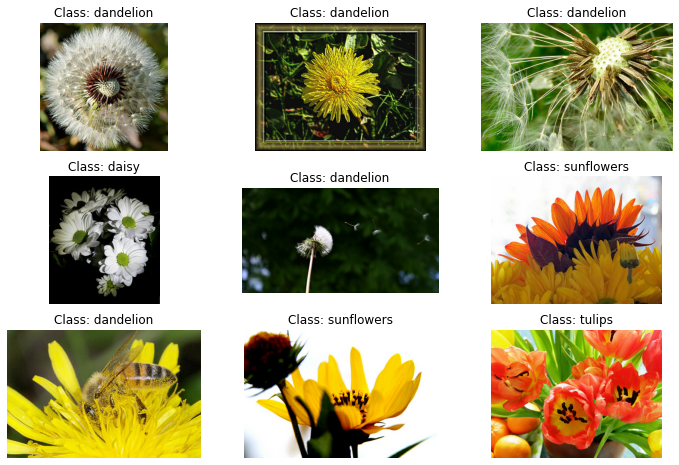

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
index = 0
sample_images = train_set_raw.take(9)
for image, label in sample_images:
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
plt.show(block=False)

## Budujemy prostą sieć CNN

W tym ćwiczeniu zbudujemy sieć o nieskompikowanej strukturze.

###  Przygotowanie danych

Sieć będzie przetwarzała obrazy o rozmiarze 224 × 224 pikseli, a więc pierwszym krokiem będzie
przetworzenie. Obiekty Dataset pozwalają na wykorzystanie metody map, która przy uczeniu
nadzorowanym będzie otrzymywała dwa argumenty (cechy, etykieta) i powinna zwracać je w postaci
krotki po przetworzeniu.

Najprostsza funkcja będzie po prostu skalowała obraz do pożądanego rozmiaru:

In [7]:
import tensorflow as tf


def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    return resized_image, label

Aplikujemy ją do pobranych zbiorów:

In [10]:
batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1) 
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

Wykorzystujemy tu dodatkowe metody Dataset API tak aby dostarczanie danych nie stało się wąskim gardłem procesu uczenia:
- shuffle losowo ustawia kolejność próbek w zbiorze uczącym,
- batch łączy próbki we wsady o podanej długości (idealnie, powinna to być wielkość miniwsadu podczas uczenia),
- prefetch zapewnia takie zarządzanie buforem, aby zawsze przygotowane było 𝑛 próbek gotowych do pobrania (w tym przypadku chcemy, aby podczas przetwarzania miniwsadu przez algorytm uczenia zawsze czekał jeden przygotowany kolejny miniwsad).


Wyświetlmy próbkę danych po przetworzeniu:

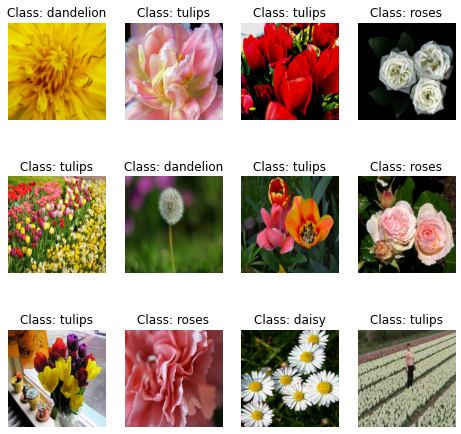

In [14]:
plt.figure(figsize=(8, 8)) 
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1) 
        plt.imshow(X_batch[index]/255.0)
        plt.title("Class: {}".format(class_names[y_batch[index]])) 
        plt.axis("off")
plt.show()

### Budowa sieci

Zaprojektuj prostą sieć konwolucyjną, która pozwoli na uzyskanie przyzwoitej dokładności klasy- fikacji przetwarzanego zbioru.

Pamiętaj o istotnych zasadach:
1. W przypadku naszych danych, ponieważ składowe RGB pikseli mają wartości z zakresu 0–255, musimy pamiętać o normalizacji danych; można użyć do tego warstwy skalującej wartości.
2. Część wykrywająca elementy obrazu składa się z warstw konwolucyjnych, najczęściej przepla- tanych warstwami zbierającymi:
- głównymi parametrami warstw konwolucyjnych są liczba filtrów i rozmiar filtra; za- zwyczaj zaczynamy od względnie niskiej liczby filtrów (np. 32) o większym rozmiarze (np. 7 × 7), aby wykryć elementarne komponenty obrazu, a na kolejnych warstwach łączymy je w bardziej złożone struktury – kombinacji jest więcej, a więc mamy coraz więcej filtrów, ale mogą być mniejszego rozmiaru (np. 3 × 3),
- zwyczajowo na jedną warstwę konwolucyjną przypadała jedna warstwa zbierająca (zm- niejszająca rozmiar „obrazu”), ale często stosujemy też kilka (np. 2) warstw kon- wolucyjnych bezpośrednio na sobie.
3. Po części konwolucyjnej typowo następuje część gęsta, złożona z warstw gęstych i opcjonalnie regularyzacyjnych (dropout?):
- część gęsta musi być poprzedzona warstwą spłaszczającą dane, gdyż spodziewa się 1- wymiarowej struktury,
- ostatnia warstwa musi być dostosowana do charakterystyki zbioru danych.

In [22]:
model = tf.keras.models.Sequential([tf.keras.layers.Rescaling(
    scale=1./127.5, offset=-1),
        tf.keras.layers.Conv2D(filters = 32,kernel_size=7, padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Conv2D(filters = 64,kernel_size=5, padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Conv2D(filters = 256,kernel_size=3, padding="same"),
        tf.keras.layers.Conv2D(filters = 256,kernel_size=3, padding="same"),
                                    tf.keras.layers.Dense(units=128, activation='relu'),
                                    tf.keras.layers.Dropout(.5),
                                    tf.keras.layers.Dense(units=64, activation='relu'),
                                    tf.keras.layers.Dropout(.5),
                                    tf.keras.layers.Dense(units=5, activation="softmax")

                                   ])


In [28]:
model.compile(loss="mse",metrics=["accuracy"], optimizer="Adam")
model.fit(train_set,validation_data=valid_set,epochs=10)

Epoch 1/10


2022-06-09 14:16:18.046421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


InternalError: Graph execution error:

Detected at node 'mean_squared_error/SquaredDifference' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/traitlets/config/application.py", line 965, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/zz/zyxvpxvq6csfxvn_n00000s4000069/T/ipykernel_26358/2087602112.py", line 2, in <cell line: 2>
      model.fit(train_set,validation_data=valid_set,epochs=10)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/losses.py", line 1329, in mean_squared_error
      return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)
Node: 'mean_squared_error/SquaredDifference'
Detected at node 'mean_squared_error/SquaredDifference' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/traitlets/config/application.py", line 965, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/zz/zyxvpxvq6csfxvn_n00000s4000069/T/ipykernel_26358/2087602112.py", line 2, in <cell line: 2>
      model.fit(train_set,validation_data=valid_set,epochs=10)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/losses.py", line 1329, in mean_squared_error
      return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)
Node: 'mean_squared_error/SquaredDifference'
2 root error(s) found.
  (0) INTERNAL:  Invalid input shapes
	 [[{{node mean_squared_error/SquaredDifference}}]]
	 [[mean_squared_error/SquaredDifference/_48]]
  (1) INTERNAL:  Invalid input shapes
	 [[{{node mean_squared_error/SquaredDifference}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_2382]

## Uczenie transferowe

### Przygotowanie danych

### Budowa sieci